In [1]:
# This command installs yfinance inside the Kaggle kernel
import os
os.system('pip install yfinance')notebook7cf75fb5bd

0

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# 1. CONFIGURATION

TICKER = "AAPL"
START_DATE = "2015-01-01"
END_DATE = "2023-12-31"
LOOKBACK_WINDOW = 60
PREDICTION_COLUMN = 'Close'

In [5]:

# 2. DATA FETCHING & FEATURE ENGINEERING

print(f"Downloading data for {TICKER}...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Technical Indicators 
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['RSI'] = calculate_rsi(df['Close'])
df['SMA_50'] = df['Close'].rolling(window=50).mean()

df = df.dropna()

features_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Signal_Line', 'SMA_50']
target_column = 'Close'


/tmp/ipykernel_55/2235844544.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [6]:

# 3. PREPROCESSING (Dual Scaler)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_X.fit_transform(df[features_list].values)
scaled_target = scaler_y.fit_transform(df[[target_column]].values)

In [7]:

# 4. CREATE SEQUENCES & PYTORCH DATASETS

def create_sequences(features, target, lookback):
    X, y = [], []
    for i in range(lookback, len(features)):
        X.append(features[i-lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target, LOOKBACK_WINDOW)

# Split Train/Test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoaders (batches data automatically)
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"X_train shape: {X_train.shape}")

  

X_train shape: (1724, 60, 9)


In [8]:

# 5. DEFINE PYTORCH MODEL

class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim_1=128, hidden_dim_2=64):
        super(StockPredictor, self).__init__()
        
        # Layer 1: Bidirectional LSTM
        # Input: (Batch, Seq, Features) -> Output: (Batch, Seq, Hidden*2)
        self.lstm1 = nn.LSTM(input_dim, hidden_dim_1, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.3)
        
        # Layer 2: LSTM
        # Input: (Batch, Seq, Hidden*2) -> Output: (Batch, Seq, Hidden_2)
        self.lstm2 = nn.LSTM(hidden_dim_1 * 2, hidden_dim_2, batch_first=True)
        
        # Batch Normalization (Applied to the output of the last timestep)
        self.batch_norm = nn.BatchNorm1d(hidden_dim_2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Dense Layers
        self.fc1 = nn.Linear(hidden_dim_2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Pass through LSTM 1
        out, _ = self.lstm1(x) 
        out = self.dropout1(out)
        
        # Pass through LSTM 2
        out, (hn, cn) = self.lstm2(out)
        
        # Select the last time step only (Many-to-One architecture)
        out = out[:, -1, :] 
        
        # Batch Norm & Dense
        out = self.batch_norm(out)
        out = self.dropout2(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

input_dim = X_train.shape[2]
model = StockPredictor(input_dim=input_dim).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

In [9]:

# 6. TRAINING LOOP (Manual Implementation)

epochs = 100
patience = 50# Early stopping patience
#Since Data is oscillating and has significant variance ...therefore we keep the patience value a bit high between 30-50 
#so that there is a balance between training (learning) and over fitting(memorization)
best_loss = float('inf')
counter = 0

print("Starting training...")

for epoch in range(epochs):
    model.train() # Set model to training mode
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()           # Clear gradients so that  it does not append previous grads 
        output = model(X_batch)         # Forward pass
        loss = criterion(output, y_batch) # Calculate loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update weights
        train_loss += loss.item()
    
    # Validation Loop
    model.eval() # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    
    # Update Scheduler
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")
    
    # Early Stopping Logic to prevent overfitting
    # avg_train_loss continues decreasing 
    #we will continue training until validation loss decreases and will stop as soon as the validation loss srarts increasing.
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth') # Save best model
    else:
        counter += 1
        if counter >= patience:
           print("Early stopping triggered.")
           break

# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

Starting training...
Epoch 1/100 | Train Loss: 0.03950 | Val Loss: 0.27433
Epoch 2/100 | Train Loss: 0.01397 | Val Loss: 0.00161
Epoch 3/100 | Train Loss: 0.01287 | Val Loss: 0.04685
Epoch 4/100 | Train Loss: 0.00901 | Val Loss: 0.03327
Epoch 5/100 | Train Loss: 0.00786 | Val Loss: 0.00081
Epoch 6/100 | Train Loss: 0.00759 | Val Loss: 0.00849
Epoch 7/100 | Train Loss: 0.00700 | Val Loss: 0.02317
Epoch 8/100 | Train Loss: 0.00579 | Val Loss: 0.01460
Epoch 9/100 | Train Loss: 0.00672 | Val Loss: 0.01557
Epoch 10/100 | Train Loss: 0.00672 | Val Loss: 0.00444
Epoch 11/100 | Train Loss: 0.00672 | Val Loss: 0.00170
Epoch 12/100 | Train Loss: 0.00483 | Val Loss: 0.00130
Epoch 13/100 | Train Loss: 0.00515 | Val Loss: 0.00560
Epoch 14/100 | Train Loss: 0.00502 | Val Loss: 0.00079
Epoch 15/100 | Train Loss: 0.00489 | Val Loss: 0.00163
Epoch 16/100 | Train Loss: 0.00370 | Val Loss: 0.00059
Epoch 17/100 | Train Loss: 0.00499 | Val Loss: 0.00332
Epoch 18/100 | Train Loss: 0.00496 | Val Loss: 0.0062

<All keys matched successfully>

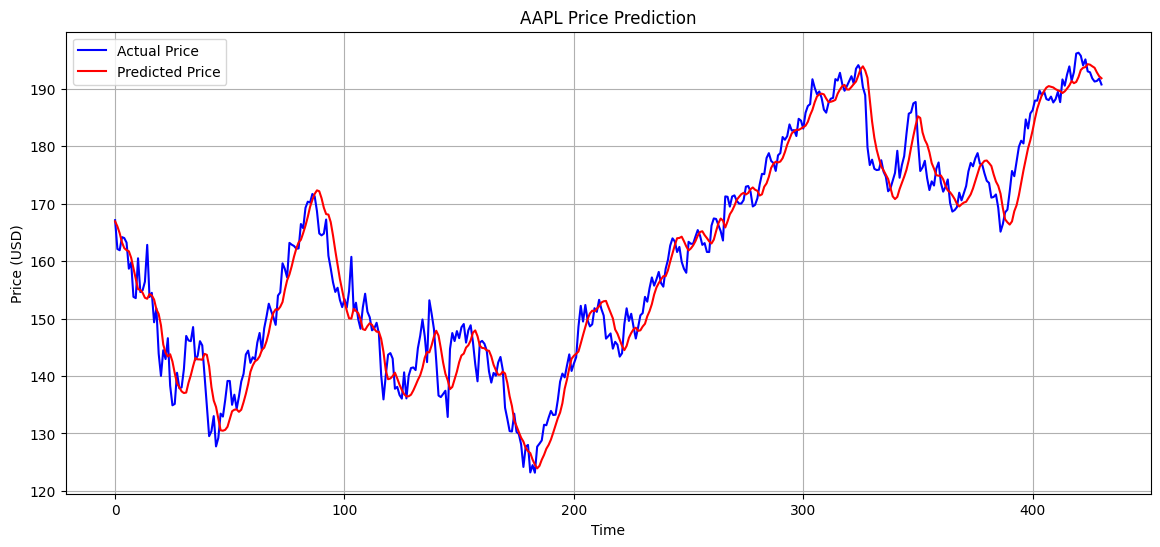

In [11]:

# 7. PREDICTION & VISUALIZATION

model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test_tensor).cpu().numpy()

# Inverse transform to get actual prices
predictions_actual = scaler_y.inverse_transform(predictions_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(predictions_actual, color='red', label='Predicted Price')
plt.title(f'{TICKER} Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()